## Image Classification

In this project, You will classify images from the CIFAR-10 dataset. The dataset consist of airplane, dogs, cats, and other objects.
You will preprocess the images , then train a convolutional neural network on all the samples. The images need to be normalized and the labels
need to be one-hot encoded. You will get to apply what you have learned and build a convoultional, max_pooling,dropout,fully connected layers. At the end, you'll get to see your neural network's predictions on the sample images.


# Get the data

Run the following cell to download the CIFAR-10->https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz dataset for python.

In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import problem_unittests as tests
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('cifar-10-python.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()


tests.test_folder_path(cifar10_dataset_folder_path)

All files found!


In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer

In [3]:
# run helper functions 
def _load_label_names():
    """
    Load the label names from file
    """
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']



def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    """
    Load a batch of the dataset
    """
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']

    return features, labels

def display_stats(cifar10_dataset_folder_path, batch_id, sample_id):
    """
    Display Stats of the the dataset
    """
    batch_ids = list(range(1, 6))

    if batch_id not in batch_ids:
        print('Batch Id out of Range. Possible Batch Ids: {}'.format(batch_ids))
        return None

    features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)

    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch {}:'.format(batch_id))
    print('Samples: {}'.format(len(features)))
    print('Label Counts: {}'.format(dict(zip(*np.unique(labels, return_counts=True)))))
    print('First 20 Labels: {}'.format(labels[:20]))

    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    label_names = _load_label_names()

    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    plt.axis('off')
    plt.imshow(sample_image)


def _preprocess_and_save(normalize, one_hot_encode, features, labels, filename):
    """
    Preprocess data and save it to file
    """
    features = normalize(features)
    labels = one_hot_encode(labels)

    pickle.dump((features, labels), open(filename, 'wb'))


def preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode):
    """
    Preprocess Training and Validation Data
    """
    n_batches = 5
    valid_features = []
    valid_labels = []

    for batch_i in range(1, n_batches + 1):
        features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_i)
        validation_count = int(len(features) * 0.1)

        # Prprocess and save a batch of training data
        _preprocess_and_save(
            normalize,
            one_hot_encode,
            features[:-validation_count],
            labels[:-validation_count],
            'preprocess_batch_' + str(batch_i) + '.p')

        # Use a portion of training batch for validation
        valid_features.extend(features[-validation_count:])
        valid_labels.extend(labels[-validation_count:])

    # Preprocess and Save all validation data
    _preprocess_and_save(
        normalize,
        one_hot_encode,
        np.array(valid_features),
        np.array(valid_labels),
        'preprocess_validation.p')

    with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    # load the training data
    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = batch['labels']

    # Preprocess and Save all training data
    _preprocess_and_save(
        normalize,
        one_hot_encode,
        np.array(test_features),
        np.array(test_labels),
        'preprocess_training.p')


def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]


def load_preprocess_training_batch(batch_id, batch_size):
    """
    Load the Preprocessed Training data and return them in batches of <batch_size> or less
    """
    filename = 'preprocess_batch_' + str(batch_id) + '.p'
    features, labels = pickle.load(open(filename, mode='rb'))

    # Return the training data in batches of size <batch_size> or less
    return batch_features_labels(features, labels, batch_size)


def display_image_predictions(features, labels, predictions):
    n_classes = 10
    label_names = _load_label_names()
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axies = plt.subplots(nrows=4, ncols=2)
    fig.tight_layout()
    fig.suptitle('Softmax Predictions', fontsize=20, y=1.1)

    n_predictions = 3
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions

    for image_i, (feature, label_id, pred_indicies, pred_values) in enumerate(zip(features, label_ids, predictions.indices, predictions.values)):
        pred_names = [label_names[pred_i] for pred_i in pred_indicies]
        correct_name = label_names[label_id]

        axies[image_i][0].imshow(feature*255)
        axies[image_i][0].set_title(correct_name)
        axies[image_i][0].set_axis_off()

        axies[image_i][1].barh(ind + margin, pred_values[::-1], width)
        axies[image_i][1].set_yticks(ind + margin)
        axies[image_i][1].set_yticklabels(pred_names[::-1])
        axies[image_i][1].set_xticks([0, 0.5, 1.0])

 ## Explore the Data

The dataset is broken into batches to prevent your machine from running out of memory. The CIFAR-10 dataset consists of 5 batches, named data_batch_1, data_batch_2, etc.. Each batch contains the labels and images that are one of the following:
-airplane

-automobile

-bird

-cat

-deer

-dog

-frog

-horse

-ship

-truck

Understanding a dataset is part of making predictions on the data. Play around with the code cell below by changing the batch_id and sample_id. The batch_id is the id for a batch (1-5). The sample_id is the id for a image and label pair in the batch.
Ask yourself "What are all possible labels?", "What is the range of values for the image data?", "Are the labels in order or random?". Answers to questions like these will help you preprocess the data and end up with better predictions.

In [4]:
%config InlineBackend.figure_format = 'retina'


# Explore the dataset
batch_id = 1
sample_id = 5
display_stats(cifar10_dataset_folder_path, batch_id,sample_id)

batch_id = 2
sample_id = 7
display_stats(cifar10_dataset_folder_path, batch_id,sample_id)


Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 5:
Image - Min Value: 0 Max Value: 252
Image - Shape: (32, 32, 3)
Label - Label Id: 1 Name: automobile

Stats of batch 2:
Samples: 10000
Label Counts: {0: 984, 1: 1007, 2: 1010, 3: 995, 4: 1010, 5: 988, 6: 1008, 7: 1026, 8: 987, 9: 985}
First 20 Labels: [1, 6, 6, 8, 8, 3, 4, 6, 0, 6, 0, 3, 6, 6, 5, 4, 8, 3, 2, 6]

Example of Image 7:
Image - Min Value: 4 Max Value: 226
Image - Shape: (32, 32, 3)
Label - Label Id: 6 Name: frog


## Implement Preprocess Functions

## Normalize

In the cell below, implement the normalize function to take in image data, x, and return it as a normalized Numpy array. The values should be in the range of 0 to 1, inclusive. The return object should be the same shape as x.

In [5]:
import numpy as np
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    # TODO: Implement Function
    x_norm = x / float(255)
    return x_norm


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_normalize(normalize)

Tests Passed


## One-hot encode
Just like the previous code cell, you'll be implementing a function for preprocessing. This time, you'll implement the one_hot_encode function. The input, x, are a list of labels. Implement the function to return the list of labels as One-Hot encoded Numpy array. The possible values for labels are 0 to 9. The one-hot encoding function should return the same encoding for each value between each call to one_hot_encode. Make sure to save the map of encodings outside the function.


In [6]:
from sklearn import preprocessing
LB = preprocessing.LabelBinarizer()
y = np.arange(10)
LB.fit(y)

def one_hot_encode(x):
    return LB.transform(x)

tests.test_one_hot_encode(one_hot_encode)

Tests Passed


## Randomize Data
As you saw from exploring the data above, the order of the samples are randomized. It doesn't hurt to randomize it again, but you don't need to for this dataset.

## Preprocess all the data and save it
Running the code cell below will preprocess all the CIFAR-10 data and save it to file. The code below also uses 10% of the training data for validation.

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# Preprocess Training, Validation, and Testing Data

preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)


In [8]:
import pickle
import problem_unittests as tests

valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

In [9]:
import tensorflow as tf

def neural_net_image_input(image_shape):
    """
    Return a tensor for a batch of image input
    :image_shape: Shape of the image
    : return: Tensor for image input.
    """
    return tf.placeholder(tf.float32, [None, image_shape[0],image_shape[1],image_shape[2]], name='x')

def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    :n_classes: Number of classes
    : return: Tensor for label input.
    """
    return tf.placeholder(tf.float32,[None, n_classes], name='y')
    
def neural_net_keep_prob_input():
    """
    Return a Tensor for keep prob
    :return : Tensor for keep prob
    """
    return tf.placeholder(tf.float32, name = 'keep_prob')

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tf.reset_default_graph()
tests.test_nn_image_inputs(neural_net_image_input)
tests.test_nn_label_inputs(neural_net_label_input)
tests.test_nn_keep_prob_inputs(neural_net_keep_prob_input)

Image Input Tests Passed.
Label Input Tests Passed.
Keep Prob Tests Passed.


In [13]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides,pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    shape = [conv_ksize[0], conv_ksize[1], x_tensor.get_shape().as_list()[-1], conv_num_outputs]
    weights = tf.Variable(tf.truncated_normal(shape=shape, mean=0.0, stddev=0.1))
    bias = tf.Variable(tf.zeros([conv_num_outputs]))
    
    conv2d = tf.nn.conv2d(x_tensor, weights, 
                          strides=[1, conv_strides[0], conv_strides[1], 1], padding='SAME')
    layer1 = tf.nn.bias_add(conv2d, bias)
    layer1 = tf.nn.relu(layer1)
    
    layer2 = tf.nn.max_pool(layer1, ksize=[1, pool_ksize[0], pool_ksize[1], 1], 
                            strides=[1, pool_strides[0],pool_strides[1], 1], padding='SAME')
    return layer2
 
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_con_pool(conv2d_maxpool)

Tests Passed


## Flatten Layer
Implement the flatten function to change the dimension of x_tensor from a 4-D tensor to a 2-D tensor. The output should be the shape (Batch Size, Flattened Image Size). You can use TensorFlow Layers or TensorFlow Layers (contrib) for this layer.


In [14]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    # TODO: Implement Function
    shape = x_tensor.get_shape()
    image_size = shape[1:4].num_elements()
    return tf.reshape(x_tensor, [-1, image_size])


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_flatten(flatten)

Tests Passed


## Fully-Connected Layer
Implement the fully_conn function to apply a fully connected layer to x_tensor with the shape (Batch Size, num_outputs). You can use TensorFlow Layers or TensorFlow Layers (contrib) for this layer.

In [15]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # TODO: Implement Function
    y_shape = x_tensor.get_shape().as_list()[-1]
    weights = tf.Variable(tf.truncated_normal(shape=[y_shape,num_outputs], mean=0.0, stddev=0.1))
    bias = tf.Variable(tf.zeros([num_outputs]))
    layer = tf.matmul(x_tensor, weights) + bias
    layer = tf.nn.relu(layer)
    return layer


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_fully_conn(fully_conn)

Tests Passed


## Output Layer
Implement the output function to apply a fully connected layer to x_tensor with the shape (Batch Size, num_outputs). You can use TensorFlow Layers or TensorFlow Layers (contrib) for this layer.
Note: Activation, softmax, or cross entropy shouldn't be applied to this.

In [16]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # TODO: Implement Function
    y_shape = x_tensor.get_shape().as_list()[-1]
    weights = tf.Variable(tf.truncated_normal(shape=[y_shape,num_outputs], mean=0.0, stddev=0.1))
    bias = tf.Variable(tf.zeros([num_outputs]))
    layer = tf.matmul(x_tensor, weights) + bias
    return layer

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_output(output)

Tests Passed


## Create Convolutional Model
Implement the function conv_net to create a convolutional neural network model. The function takes in a batch of images, x, and outputs logits. Use the layers you created above to create this model:
Apply 1, 2, or 3 Convolution and Max Pool layers
Apply a Flatten Layer
Apply 1, 2, or 3 Fully Connected Layers
Apply an Output Layer
Return the output
Apply TensorFlow's Dropout to one or more layers in the model using keep_prob.

In [17]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    # TODO: Apply 1, 2, or 3 Convolution and Max Pool layers
    #    Play around with different number of outputs, kernel size and stride
    # Function Definition from Above:
    x_tensor = x
    conv_num_outputs = 16
    conv_ksize = (4,4)
    conv_strides = (1,1)
    pool_ksize = (2,2)
    pool_strides = (2,2)
    conv1 = conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides)
    
    conv_num_outputs = 32
    conv2 = conv2d_maxpool(conv1, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides)
    
    conv_num_outputs = 64
    conv3 = conv2d_maxpool(conv2, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides)
    
    x_tensor = conv3
    # TODO: Apply a Flatten Layer
    # Function Definition from Above:
    x_tensor = flatten(x_tensor)

    # TODO: Apply 1, 2, or 3 Fully Connected Layers
    #    Play around with different number of outputs
    # Function Definition from Above:
    num_outputs = 10
    x_tensor = fully_conn(x_tensor, num_outputs)
    x_tensor = tf.nn.dropout(x_tensor, keep_prob)
    
    # TODO: Apply an Output Layer
    #    Set this to the number of classes
    # Function Definition from Above:
    x_tensor = output(x_tensor, num_outputs)
    
    
    # TODO: return output
    return x_tensor


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

##############################
## Build the Neural Network ##
##############################

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

tests.test_conv_net(conv_net)

Neural Network Built!


## Train the Neural Network
Single Optimization
Implement the function train_neural_network to do a single optimization. The optimization should use optimizer to optimize in session with a feed_dict of the following:
x for image input
y for labels
keep_prob for keep probability for dropout
This function will be called for each batch, so tf.global_variables_initializer() has already been called.
Note: Nothing needs to be returned. This function is only optimizing the neural network.

In [18]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    # TODO: Implement Function
    session.run(optimizer,feed_dict={x:feature_batch, y:label_batch, keep_prob:keep_probability})


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_train_nn(train_neural_network)

Tests Passed


## Show Stats
Implement the function print_stats to print loss and validation accuracy. Use the global variables valid_features and valid_labels to calculate validation accuracy. Use a keep probability of 1.0 to calculate the loss and validation accuracy.

In [19]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    # TODO: Implement Function
    
    # Calculate batch loss and accuracy
    loss = session.run(cost, feed_dict={x: feature_batch, y: label_batch, keep_prob: 1.})
    valid_acc = session.run(accuracy, feed_dict={x: valid_features, y: valid_labels, keep_prob: 1.})

    print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(loss, valid_acc))
    pass

## Hyperparameters
Tune the following parameters:
Set epochs to the number of iterations until the network stops learning or start overfitting
Set batch_size to the highest number that your machine has memory for. Most people set them to common sizes of memory:
64
128
256
...
Set keep_probability to the probability of keeping a node using dropout

In [20]:
# TODO: Tune Parameters
epochs = 30
batch_size = 128
keep_probability = 0.75

## Train on a Single CIFAR-10 Batch
Instead of training the neural network on all the CIFAR-10 batches of data, let's use a single batch. This should save time while you iterate on the model to get a better accuracy. Once the final validation accuracy is 50% or greater, run the model on all the data in the next section.

In [22]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)

Checking the Training on a Single Batch...
Epoch  1, CIFAR-10 Batch 1:  Loss:     2.1729 Validation Accuracy: 0.192200
Epoch  2, CIFAR-10 Batch 1:  Loss:     2.0638 Validation Accuracy: 0.278800
Epoch  3, CIFAR-10 Batch 1:  Loss:     1.9859 Validation Accuracy: 0.312200
Epoch  4, CIFAR-10 Batch 1:  Loss:     1.9500 Validation Accuracy: 0.331800
Epoch  5, CIFAR-10 Batch 1:  Loss:     1.8625 Validation Accuracy: 0.337600
Epoch  6, CIFAR-10 Batch 1:  Loss:     1.8093 Validation Accuracy: 0.348000
Epoch  7, CIFAR-10 Batch 1:  Loss:     1.7315 Validation Accuracy: 0.361200
Epoch  8, CIFAR-10 Batch 1:  Loss:     1.6851 Validation Accuracy: 0.355000
Epoch  9, CIFAR-10 Batch 1:  Loss:     1.6328 Validation Accuracy: 0.371400
Epoch 10, CIFAR-10 Batch 1:  Loss:     1.5891 Validation Accuracy: 0.383400
Epoch 11, CIFAR-10 Batch 1:  Loss:     1.5587 Validation Accuracy: 0.377800
Epoch 12, CIFAR-10 Batch 1:  Loss:     1.4935 Validation Accuracy: 0.400400
Epoch 13, CIFAR-10 Batch 1:  Loss:     1.4776

## Fully Train the Model
Now that you got a good accuracy with a single CIFAR-10 batch, try it with all five batches.

In [24]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  Loss:     2.2206 Validation Accuracy: 0.200000
Epoch  1, CIFAR-10 Batch 2:  Loss:     2.0089 Validation Accuracy: 0.267000
Epoch  1, CIFAR-10 Batch 3:  Loss:     1.6632 Validation Accuracy: 0.311600
Epoch  1, CIFAR-10 Batch 4:  Loss:     1.7139 Validation Accuracy: 0.347000
Epoch  1, CIFAR-10 Batch 5:  Loss:     1.7249 Validation Accuracy: 0.369200
Epoch  2, CIFAR-10 Batch 1:  Loss:     1.8616 Validation Accuracy: 0.372000
Epoch  2, CIFAR-10 Batch 2:  Loss:     1.7076 Validation Accuracy: 0.382800
Epoch  2, CIFAR-10 Batch 3:  Loss:     1.3176 Validation Accuracy: 0.402800
Epoch  2, CIFAR-10 Batch 4:  Loss:     1.5910 Validation Accuracy: 0.404600
Epoch  2, CIFAR-10 Batch 5:  Loss:     1.5152 Validation Accuracy: 0.435400
Epoch  3, CIFAR-10 Batch 1:  Loss:     1.7107 Validation Accuracy: 0.450600
Epoch  3, CIFAR-10 Batch 2:  Loss:     1.4592 Validation Accuracy: 0.467000
Epoch  3, CIFAR-10 Batch 3:  Loss:     1.2030 Validation Accuracy: 0.462200


## Checkpoint
The model has been saved to disk.
## Test Model
Test your model against the test dataset. This will be your final accuracy. You should have an accuracy greater than 50%. If you don't, keep tweaking the model architecture and parameters.

Testing Accuracy: 0.6204509493670886



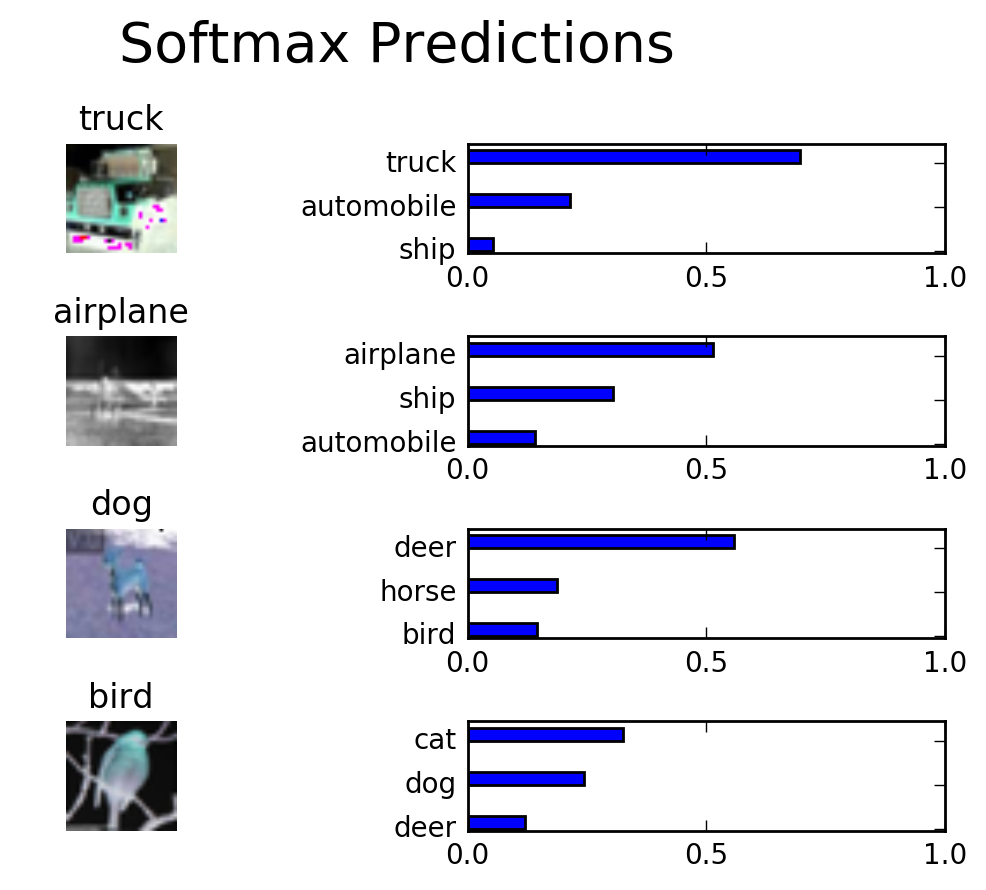

In [28]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import random

# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_training.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for train_feature_batch, train_label_batch in batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()

# Why 50-70% Accuracy?
You might be wondering why you can't get an accuracy any higher. First things first, 50% isn't bad for a simple CNN. Pure guessing would get you 10% accuracy. However, you might notice people are getting scores well above 70%. That's because we haven't taught you all there is to know about neural networks. We still need to cover a few more techniques.